# Homework 6

The focus of this homework will be Network and Graphs as well as Neural Networks.

## Exercise 1 [25pts]

In this exercise, you will try to recommend new collaborations to researchers
of the Machine Learning community. Our approach will follow the guidelines of
collaborative filtering: “If your past behavior/preferences were similar
to some other user’s, your future behavior may be as well”. As an
example, imagine you like Rolling Stones, Beatles and Jimmy Hendrix. It turns
out that most people that like the aforementioned artists, are also fans of Eric
Clapton. Then, it is very likely that if you listen to Eric Clapton’s music, you
will like it as well.

In this assignment you will implement a recommendation system for suggesting new collaborations to Machine Learning researchers.

A network as a graph: A graph or network represents relationships among
different entities (users of a social network, researchers, products, etc.). Those
entities are represented as nodes and the relationships between them (friends
on Facebook, co-authors of a research paper, products purchased together) as
edges. When there is an edge between two nodes, x and y, we say that y is a
neighbor (or friend) of x (and also - as the graphs we consider are undirected -
x is also a neighbor of y).

Each line of `edges.txt` contains the names of two researchers that have co-authored a paper in one of the top Machine Learning conferences (NeurIPS, ICLR, ICML) between 2010 and 2016.

a) Write a function that reads the file “old edges.txt” and create a
graph using NetworkX. (This is a tab-separated value (TSV) file, you may
use packages such as Pandas to read it.) [5pts]

In [1]:
import networkx as nx
import pandas as pd 

def graphEdges(txtname):
    df = pd.read_csv(txtname, sep='\t', names = ['Edge1', 'Edge2'])
    g = nx.from_pandas_edgelist(df, 'Edge1', 'Edge2')
    return g

g = graphEdges('edges.txt')

b) Recommend by number of common friends. [10pts]

The intuition behind this recommendation algorithm is that if non-friend
Y is your friend’s friend, then maybe Y should be your friend too. If
person Y is the friend of many of your friends, then Y is an even better
recommendation.

Write a function `common_friends_number(G, X)` that, given G and an author
X, returns a list of recommendations for X. The authors in this list are sorted
by the number of common neighbors they have with X (and are not of course
already friends with X). If there are ties, you can break them arbitrarily.

In [2]:
def common_friends_number(G, X):
    commons_list = {}
    gneighbors = list(G.neighbors(X))
    for e in G.neighbors(X):
        for e2 in G.neighbors(e):
            if e2 == X or e2 in gneighbors:
                continue
            if e2 in commons_list:
                commons_list[e2] += 1
            else:
                commons_list[e2] = 1
    commons_list = list(commons_list.items())
    # Sort by the number of count 
    commons_list.sort(key = lambda x: x[1], reverse = True)
    name_list = [x[0] for x in commons_list]
    return name_list

# Example 
common_friends_number(g, 'Mladen Kolar')[:10]

['Larry A. Wasserman',
 'Akshay Krishnamurthy',
 'Srivatsan Narayanan',
 'Min Xu',
 'Yu-Xiang Wang',
 'Jisu Kim',
 'Yen-Chi Chen',
 'Haesun Park',
 'Le Song',
 'Mariya Ishteva']

c) Make recommendations using Jaccard’s Index. [10points]

If Γ(X) is the set of neighbors of X, then the metric we used in part (c), assigns to a non-friend y, the following recommendation score (with respect to X):

score(y) = |Γ(X)∩Γ(y)|.

Jaccard’s Index scales this score by taking into account the union of X and Y ’s neighbors. Intuitively, X and Y are more similar, if what they have in common is as close as possible to what they have together.

Write a function jaccard index(G, X) that given G and an author X, returns a
list of recommendations for X. The authors in this list are sorted by the number
of their Jaccard Index with respect to X (and are not of course already friends
with X). If there are ties, you can break them arbitrarily.

Jaccard Index = |Γ(X)∩Γ(y)| / |Γ(X)∪Γ(y)|

In [3]:
def jaccard_index(G, X):
   commons_list = []
   Xlist = set(G.neighbors(X))
   for e in G.neighbors(X):
      for e2 in G.neighbors(e):
         if e2 == X or e2 in Xlist:
            continue
         elist = [x for x in G.neighbors(e2)]
         elist = set(elist)
         sim = float(len(Xlist.intersection(elist)) / len(Xlist.union(elist)))
         if (e2, sim) not in commons_list:
            commons_list.append((e2 , sim))
         # Sort by the number of count 
         commons_list.sort(key = lambda x: x[1], reverse = True)
         name_list = [x[0] for x in commons_list]
   return name_list

jaccard_index(g, 'Mladen Kolar')[:10]

['Srivatsan Narayanan',
 'Qingming Tang',
 'Jisu Kim',
 'Mariya Ishteva',
 'Min Xu',
 'Yen-Chi Chen',
 'Akshay Krishnamurthy',
 'Haesun Park',
 'Larry A. Wasserman',
 'Yu-Xiang Wang']

## Exercise 2 [55pts]

This exercise will focus on Neural Networks and visualization.

a) Write a function that takes a keras network and outputs an image (png format) of the network. [10pts]

You can assume the model is sequential and only uses dense layers. The output image for

```python
    model = keras.models.Sequential()
    model.add(layers.Dense(2, input_dim=2))
    model.add(layers.Dense(1))
    model.compile(loss="binary_crossentropy")
```

should look something like this

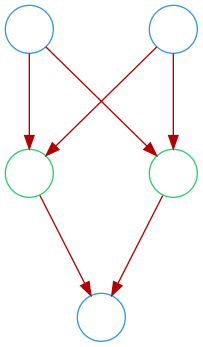

In [4]:
from IPython.display import Image
Image(filename="example.png")

Hint: use the networkx library (specifically the [to_agraph](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_agraph.to_agraph.html) method)

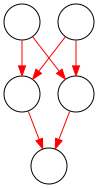

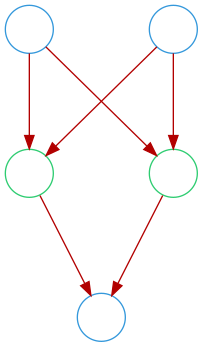

In [5]:
import keras
from keras.utils.vis_utils import plot_model
from networkx.drawing import nx_pydot
from graphviz import Source
from kviz.dense import DenseGraph

# first version
def network_to_image(model):
    G = nx.DiGraph()
    firstlayer = model.layers[0]
    (_, fnumShape)= firstlayer.input_shape
    numnode = 1
    parentNum = fnumShape
    parentNode = 1
    for _ in range(fnumShape):
        G.add_node(numnode, shape ='circle', label = '')
        numnode += 1

    for layer in model.layers:
        (_, numShape) = layer.output_shape
        for _ in range(numShape):
            G.add_node(numnode, shape ='circle', label = '')
        
            for i in range(parentNum):
                if (parentNode+i != numnode):
                    G.add_edge(parentNode+i, numnode, color = 'red') 
            numnode += 1  
        parentNode += parentNum
        parentNum = numShape   
    nx_pydot.write_dot(G, 'Dag')
    return Source.from_file('Dag')

# second version
def network_to_image2 (model):
    dg = DenseGraph(model)
    dg.render('ex2')
    return Image(filename='ex2.png')  

model = keras.models.Sequential()
model.add(keras.layers.Dense(2, input_dim=2))
model.add(keras.layers.Dense(1))
model.compile(loss="binary_crossentropy")
display(network_to_image(model))
display(network_to_image2(model))


b) Generate 100 datapoints of the form y = 3x + 1 + e where e ~ N(0, 1) and plot the data in a scatter plot [5pts]

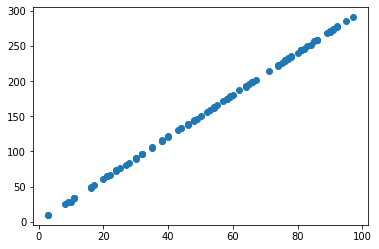

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

count = 100
mean = 0
std = 1
data_points = []
for _ in range(count):
    e = np.random.normal(mean, std)
    x = random.randint(1, 100)  #temporary 
    data_points.append([x,3*x+1+e])
data_points = np.array(data_points)

plt.scatter(data_points[:, 0], data_points[:, 1]) 
plt.show() 

c) Create a Neural Network with no hidden layers (just input to ouput each with just one neuron), using the `mean_squared_error` loss and no activation function. Create an image of this model using a) then train this model on the dataset from b). In a 3D plot, plot the weight, the bias, and the loss value. [10pts]

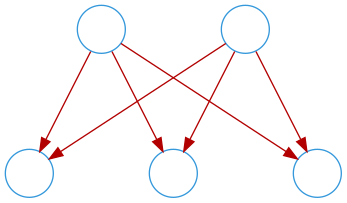

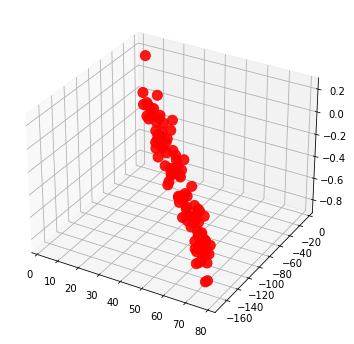

In [13]:
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

model = keras.models.Sequential()
model.add(keras.layers.Dense(3, input_dim=2))
model.compile(loss = 'mean_squared_error')
y = network_to_image2(model)
display(y)

sample_points = []
for _ in range(count):
    x = random.randint(1, 100)
    sample_points.append(x)
sample_points = np.array(sample_points)

hist = model.fit(data_points, sample_points, batch_size = 50, verbose = 0)

layer = model.layers[0]
keras_function = keras.backend.function([model.input], [layer.output])
layerVals = np.array(keras_function(data_points))[0]
fig = plt.figure(figsize= [8, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(layerVals[:,0], layerVals[:, 1], layerVals[:, 2], color='red', s=100, alpha=.9)
plt.show()

d) Using matplotlib animation, re-train the model from c) and create an animation of the weight, bias, and loss at each training epoch. [10pts]

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation


hist = model.fit(data_points, sample_points, batch_size = 50, verbose = 0, epochs = 100)

def update(x):
    layer = model.layers[0]
    keras_function = keras.backend.function([model.input], [layer.output])
    layerVals = np.array(keras_function(data_points))[0]
    line.set_data(layerVals[:,0], layerVals[:, 1]) 
    line.set_3d_propeties(layerVals[:, 2])
    return 



fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ani = animation.FuncAnimation(fig, update, frames = 100, interval = 10, blit = True)

e) Generate data of the form y = 3x^3 + 2x^2 + x + 1 + e where e ~ N(0, 1) and plot the data in a scatter plot [5pts]

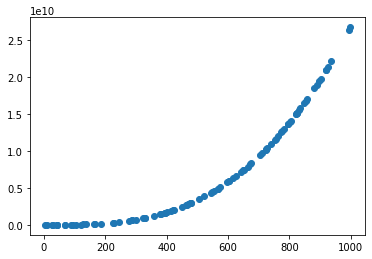

In [31]:
count = 100
mean = 0
std = 1
X = []
for _ in range(count):
    e = np.random.normal(mean, std)
    x = random.randint(1, 1000)  #temporary         
    X.append([x, (3*x)**3 + (2*x)**2 + x + 1 + e])
X = np.array(X)

plt.scatter(X[:, 0], X[:, 1]) 
plt.show() 

f) Create and train a neural network on the dataset from b) and plot the resulting curve through the scatter plot. (you can use any number of epochs, hidden layers etc.) Also create an image of the network using the function from a) [10pts]

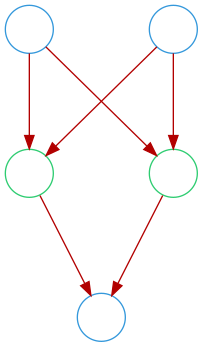

Epoch 1/100
2/2 [==============================] - 1s 6ms/step - loss: -449.5092 - accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: -451.5350 - accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: -453.6684 - accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: -455.7320 - accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: -457.7545 - accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: -459.9292 - accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: -461.9785 - accuracy: 0.0000e+00
Epoch 8/100
2/2 [==============================] - 0s 7ms/step - loss: -464.0392 - accuracy: 0.0000e+00
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: -466.1946 - accuracy: 0.0000e+00
Epoch 10/100
2/2 [==============================] - 0s 6ms/step 

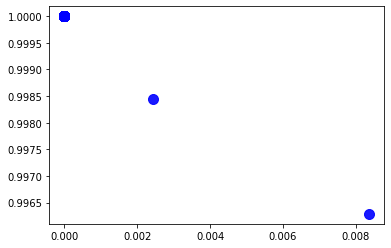

In [120]:
from sklearn.model_selection import train_test_split

model = keras.models.Sequential()
model.add(keras.layers.Dense(2, input_dim=2, activation="sigmoid"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
y = network_to_image2(model)
display(y)

Y = []
for _ in range(count):
    x = random.randint(1, 1000)
    Y.append(x)
Y = np.array(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42)

hist = model.fit(x_train, y_train, batch_size = 50, epochs = 100)

layer = model.layers[0]
keras_function = keras.backend.function([model.input], [layer.output])
layerVals = np.array(keras_function(data_points))[0]
plt.scatter(layerVals[:,0], layerVals[:, 1], color= 'blue', s=100, alpha=.9)
plt.show()


g) Using matplotlib animation, create an animation of the resulting curve from your model at each training epoch (up to 100 epochs). [5pts]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


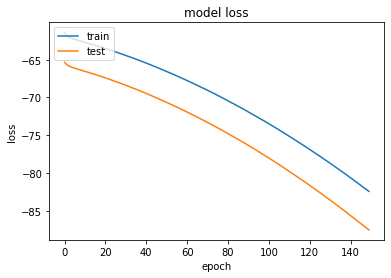

In [121]:
history = model.fit(data_points, sample_points, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
print(history.history.keys())


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation 
   
fig = plt.figure() 
axis = plt.axes(xlim =(100, 110), 
                ylim =(0, 400)) 
  
# initializing a line variable
line, = axis.plot([], [], lw = 3) 

def init(): 
    line.set_data([], [])
    return line,
   
def animate(i):
    x = np.linspace(100, 110, 10)
    y = model.fit(x_train, y_train, batch_size = 50, epochs = x*i)
    line.set_data(x, y)
      
    return line,
   
anim = FuncAnimation(fig, animate, init_func = init,
                     frames = 2, interval = 20, blit = True)

anim.save('graph.mp4', writer = 'ffmpeg', fps = 100)


## Exercise 3 [20pts]

This exercise will focus on Neural Networks.



In [198]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms 
from torch.optim import SGD, Adam
from tqdm import tqdm 

a) Modify the number of layers to include atleast 2 hidden layers with appropriate number of neurons that use the sigmoid function in the forward pass: [5pts]

In [207]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size):
    super(NeuralNetwork, self).__init__()
    # You are free to define any number of layers you want to here
    self.flatten = nn.Flatten()
    self.layer1 = nn.Linear(input_size, 800)
    self.layer2 = nn.Linear(800, 300)
    self.layer3 = nn.Linear (300, 300)
    self.output = nn.Linear(300, 10)  
    self.dropout = nn.Dropout(0.3)


  def forward(self, input):
    x = F.relu(self.layer1(input))
    # x = F.sigmoid(self.layer1(input))
    x = F.sigmoid(self.layer2(x))
    x = F.sigmoid(self.layer3(x))
    x = self.dropout(x)
    outputs = self.output(x)
    return F.softmax(outputs)

b) Modify the following values to provide the highest accuracy on your Neural Network [2pts]

In [208]:
epochs = 7     # number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # device
criterion = nn.CrossEntropyLoss() # loss function
batch_size = 321

Run the following cell everytime you update parts a and b

In [209]:
net = NeuralNetwork(784).to(device)
optimizer = Adam(net.parameters(), lr = 1e-2)

total_loss = 0


#######################################
### Downloading the data


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True, num_workers=2, drop_last=True)
train_dataloader2 = torch.utils.data.DataLoader(training_data, batch_size = batch_size, shuffle = True, num_workers=2, drop_last = True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers=2, drop_last=True)
test_dataloader2 = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers=2, drop_last = True)

c) You may change the model to increase the accuracy of this model. The goal is to attain the highest possible accuracy. You do not get marks for accuracies less than 83%. You may modify the values in parts a and b [8pts]

In [210]:
for epoch in tqdm(range(epochs)): 
  epoch_loss = 0
  for i, data in enumerate(train_dataloader): 
    inputs, labels = data 

    optimizer.zero_grad() 
    outputs = net(inputs.view(batch_size,-1).to(device))

    labels_ = F.one_hot(labels, num_classes= 10)

    loss = criterion(outputs,labels_.to(device).float())
    loss.backward()  # update network parameters

    optimizer.step() # update the optimizer parameters 

    total_loss += loss.item() 
    epoch_loss += loss.item()
  
  with torch.no_grad():
    net.eval()
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader2):
      input, labels = data
      outputs = net(input.view(batch_size,-1).to(device))

      total+= len(labels)

      predictions = torch.argmax(outputs, dim = 1)
      predictions = predictions.to("cpu").numpy() 
      correct += sum(1*(labels.numpy()==predictions))
  
  with torch.no_grad():
    net.eval()
    correct_test = 0
    total_test = 0
    for i, data in enumerate(test_dataloader):
      input, labels = data
      outputs = net(input.view(batch_size,-1).to(device))

      total_test+= len(labels)

      predictions = torch.argmax(outputs, dim = 1)
      predictions = predictions.to("cpu").numpy() 
      correct_test += sum(1*(labels.numpy()==predictions))

  print( " — epoch loss = %1.2f — training accuracy = %1.2f — test accuracy = %1.2f" %( epoch_loss, correct/total, correct_test/total_test))

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\3eypa\AppData\Local\Temp\ipykernel_4664\1309115157.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(outputs)
 14%|█▍        | 1/7 [00:32<03:13, 32.24s/it]

 — epoch loss = 363.22 — training accuracy = 0.57 — test accuracy = 0.57


 29%|██▊       | 2/7 [01:10<02:58, 35.77s/it]

 — epoch loss = 346.57 — training accuracy = 0.63 — test accuracy = 0.63


 43%|████▎     | 3/7 [01:48<02:26, 36.62s/it]

 — epoch loss = 337.01 — training accuracy = 0.69 — test accuracy = 0.68


 57%|█████▋    | 4/7 [02:29<01:55, 38.34s/it]

 — epoch loss = 327.56 — training accuracy = 0.70 — test accuracy = 0.69


 71%|███████▏  | 5/7 [03:08<01:17, 38.64s/it]

 — epoch loss = 327.33 — training accuracy = 0.67 — test accuracy = 0.66


 86%|████████▌ | 6/7 [03:46<00:38, 38.36s/it]

 — epoch loss = 327.38 — training accuracy = 0.69 — test accuracy = 0.68


100%|██████████| 7/7 [04:29<00:00, 38.43s/it]

 — epoch loss = 327.48 — training accuracy = 0.71 — test accuracy = 0.70


d) Explain in ~150 words the method you used to increase the accuracy. [5pts]


First, I tried 10 epochs and 500 batch_size. Then I tried to increase epochs by 5 and it didn't work well. Then I tried to decrease epochs by 1 and decided to set epochs to 7. I realized that too many epochs will not necessarily improve the accuracy and instead may cause the model to over-fit the training data. Next, I tried to increase batch_size by 100 and it didn't work well. Then I tried to decrease batch_size by 100 and I achieved . I got worst result when I tried 15 epochs and 400 batch_size which gave me 0.45 accuracy for both train and test. I got 0.84 training accuracy and 0.83 test accuracy when epoch is 7 and batch_size is 321
